In [1]:
!pip install numpy scipy matplotlib corner pandas


In [11]:
import numpy as np

# Charger le fichier avec entête
data = np.genfromtxt("data/Pantheon+SH0ES.dat", names=True)

# Colonnes utiles
z = data["zHD"]          # redshift
mu_obs = data["MU_SH0ES"]  # module de distance observé

print("Nb SNe:", len(mu_obs))
print("z[0:5] =", z[:5])
print("mu_obs[0:5] =", mu_obs[:5])


Nb SNe: 1701
z[0:5] = [0.00122 0.00122 0.00256 0.00256 0.00299]
mu_obs[0:5] = [28.9987 29.0559 30.7233 30.7449 30.7757]


In [13]:
# Charger directement les matrices carrées
C_tronque_raw = np.loadtxt("data/Pantheon+SH0ES_STAT+SYS.cov")
C_stat        = np.loadtxt("data/Pantheon+SH0ES_STATONLY.cov")

print("Shape tronqué brut:", C_tronque_raw.shape)
print("Shape statonly:", C_stat.shape)
print("Nb SNe (données):", len(mu_obs))


Shape tronqué brut: (2893402,)
Shape statonly: (2893402,)
Nb SNe (données): 1701


In [15]:
# Créer un dossier "data"
!mkdir -p data

# Télécharger un fichier avec curl ou wget
!curl -L -o data/Pantheon+SH0ES.dat \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat"

!curl -L -o data/Pantheon+SH0ES_STAT+SYS.cov \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov"

!curl -L -o data/Pantheon+SH0ES_STATONLY.cov \
  "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STATONLY.cov"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  565k  100  565k    0     0  4675k      0 --:--:-- --:--:-- --:--:-- 4714k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.7M  100 31.7M    0     0  54.6M      0 --:--:-- --:--:-- --:--:-- 54.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30.3M  100 30.3M    0     0  68.7M      0 --:--:-- --:--:-- --:--:-- 68.8M


In [16]:
!ls -lh data
!head -n 3 data/Pantheon+SH0ES.dat
!wc -l data/Pantheon+SH0ES_STAT+SYS.cov


total 63M
-rw-r--r-- 1 root root 566K Oct  8 20:00 Pantheon+SH0ES.dat
-rw-r--r-- 1 root root  31M Oct  8 20:00 Pantheon+SH0ES_STATONLY.cov
-rw-r--r-- 1 root root  32M Oct  8 20:00 Pantheon+SH0ES_STAT+SYS.cov
CID IDSURVEY zHD zHDERR zCMB zCMBERR zHEL zHELERR m_b_corr m_b_corr_err_DIAG MU_SH0ES MU_SH0ES_ERR_DIAG CEPH_DIST IS_CALIBRATOR USED_IN_SH0ES_HF c cERR x1 x1ERR mB mBERR x0 x0ERR COV_x1_c COV_x1_x0 COV_c_x0 RA DEC HOST_RA HOST_DEC HOST_ANGSEP VPEC VPECERR MWEBV HOST_LOGMASS HOST_LOGMASS_ERR PKMJD PKMJDERR NDOF FITCHI2 FITPROB m_b_corr_err_RAW m_b_corr_err_VPEC biasCor_m_b biasCorErr_m_b biasCor_m_b_COVSCALE biasCor_m_b_COVADD
2011fe 51 0.00122 0.00084 0.00122 2e-05 0.00082 2e-05 9.74571 1.51621 28.9987 1.51645 29.177 1 0 -0.1076 0.04008 -0.548188 0.13373 9.58436 0.0327221 2.63181 0.0793177 0.00011378 -0.00052525 -0.00272765 210.774 54.2737 -999 -999 -9 0 250 0.00758935 10.677 -9 55815 0.1071 36 26.8859 0.86447 0.0991 1.496 0.0381 0.005 1 0.003
2011fe 56 0.00122 0.00084 0.00122 2e-0

In [18]:
import numpy as np

N = len(mu_obs)  # 1701

# Charger en sautant la première ligne
C_tronque_flat = np.loadtxt("data/Pantheon+SH0ES_STAT+SYS.cov", skiprows=1)
C_stat_flat    = np.loadtxt("data/Pantheon+SH0ES_STATONLY.cov", skiprows=1)

print("Tailles brutes:", C_tronque_flat.shape, C_stat_flat.shape)

# Reshape en matrices carrées
C_tronque_raw = C_tronque_flat.reshape((N, N))
C_stat        = C_stat_flat.reshape((N, N))

print("Shapes carrées:", C_tronque_raw.shape, C_stat.shape)


Tailles brutes: (2893401,) (2893401,)
Shapes carrées: (1701, 1701) (1701, 1701)


In [19]:
def make_spd(C):
    C = 0.5*(C + C.T)
    w, v = np.linalg.eigh(C)
    w = np.clip(w, 1e-12, None)
    return v @ np.diag(w) @ v.T

C_tronque_corr = make_spd(C_tronque_raw)
C_stat         = make_spd(C_stat)

alpha = 0.8
C_blend = alpha*C_tronque_corr + (1-alpha)*C_stat

print("Eigmin tronqué corrigé:", np.min(np.linalg.eigvalsh(C_tronque_corr)))
print("Eigmin blend:", np.min(np.linalg.eigvalsh(C_blend)))


Eigmin tronqué corrigé: 0.0008027816532254051
Eigmin blend: 0.0007981121889876591


In [20]:
from scipy.integrate import quad

c = 299792.458  # km/s

# --- Modèle cosmologique ---
def E_inv(z, Om):
    return 1.0 / np.sqrt(Om*(1+z)**3 + (1-Om))

def dL_single(z, H0, Om):
    integral, _ = quad(E_inv, 0, z, args=(Om,))
    return (c/H0) * (1+z) * integral

def dL_vec(z_arr, H0, Om):
    return np.array([dL_single(zi, H0, Om) for zi in z_arr])

def mu_theory(z_arr, H0, Om, M):
    return 5*np.log10(dL_vec(z_arr, H0, Om)) + 25 + M

# --- Pré-calculs pour les deux covariances ---
N = len(mu_obs)

Cinvt_tronque = np.linalg.inv(C_tronque_corr)
sign_t, logdet_t = np.linalg.slogdet(C_tronque_corr)
const_norm_t = -0.5 * (N*np.log(2*np.pi) + logdet_t)

Cinvt_blend = np.linalg.inv(C_blend)
sign_b, logdet_b = np.linalg.slogdet(C_blend)
const_norm_b = -0.5 * (N*np.log(2*np.pi) + logdet_b)

# --- Vraisemblances ---
def lnlike_tronque(params):
    H0, Om, M = params
    if not (40 < H0 < 100) or not (0 < Om < 1) or not (-1 < M < 1):
        return -np.inf
    mu_mod = mu_theory(z, H0, Om, M)
    r = mu_obs - mu_mod
    return const_norm_t - 0.5 * np.dot(r, Cinvt_tronque @ r)

def lnlike_blend(params):
    H0, Om, M = params
    if not (40 < H0 < 100) or not (0 < Om < 1) or not (-1 < M < 1):
        return -np.inf
    mu_mod = mu_theory(z, H0, Om, M)
    r = mu_obs - mu_mod
    return const_norm_b - 0.5 * np.dot(r, Cinvt_blend @ r)


In [22]:
import numpy as np

def run_mcmc(theta0, lnlike, prop_scales, Nsteps, burn, rng):
    """MCMC Metropolis simple, optimisé pour Colab (ManyPower)."""
    ndim = len(theta0)
    chain = np.empty((Nsteps, ndim))
    theta = np.array(theta0, dtype=float)
    lncur = lnlike(theta)
    accept = 0

    # Tirages vectorisés
    props = rng.normal(0, prop_scales, size=(Nsteps, ndim))
    uniforms = rng.random(Nsteps)

    for i in range(Nsteps):
        cand = theta + props[i]
        lnnew = lnlike(cand)
        if lnnew - lncur >= np.log(uniforms[i]):
            theta, lncur = cand, lnnew
            accept += 1
        chain[i] = theta

    return chain[burn:], accept / Nsteps

def summary(samples):
    q16, q50, q84 = np.percentile(samples, [16, 50, 84])
    return dict(mean=np.mean(samples), std=np.std(samples), q16=q16, q50=q50, q84=q84)

# --- Lancer les deux runs ---
rng = np.random.default_rng(42)
theta0 = [67.0, 0.3, -0.2]

post_tronque, acc_t = run_mcmc(theta0, lnlike_tronque, [0.5, 0.02, 0.02], 6000, 1000, rng)
post_blend,   acc_b = run_mcmc(theta0, lnlike_blend,   [0.4, 0.015, 0.015], 8000, 2000, rng)

print(f"Acceptation tronqué: {acc_t:.3f} | blend: {acc_b:.3f}")
for name, idx in zip(["H0","Ωm","M"], range(3)):
    print(f"{name} tronqué:", summary(post_tronque[:,idx]))
    print(f"{name} blend:  ", summary(post_blend[:,idx]))


Acceptation tronqué: 0.130 | blend: 0.190
H0 tronqué: {'mean': np.float64(58.82960889394588), 'std': np.float64(4.34515026184631), 'q16': np.float64(54.17566198272142), 'q50': np.float64(58.99241986201489), 'q84': np.float64(63.12059847076354)}
H0 blend:   {'mean': np.float64(67.30853240001687), 'std': np.float64(2.8073107991467703), 'q16': np.float64(64.44010817116508), 'q50': np.float64(66.84879335752865), 'q84': np.float64(70.3494240333849)}
Ωm tronqué: {'mean': np.float64(0.36200315163271446), 'std': np.float64(0.017808248359502718), 'q16': np.float64(0.34453023382323034), 'q50': np.float64(0.3606909039962474), 'q84': np.float64(0.37915010852233083)}
Ωm blend:   {'mean': np.float64(0.36351721414854393), 'std': np.float64(0.018970239073897263), 'q16': np.float64(0.3444515067105102), 'q50': np.float64(0.36481262897331557), 'q84': np.float64(0.38181390120889985)}
M tronqué: {'mean': np.float64(-0.4695147948444974), 'std': np.float64(0.1586747903454368), 'q16': np.float64(-0.6429493616

In [23]:
def stability(medA, sigA, medB, sigB):
    return abs(medA - medB) / np.sqrt(sigA**2 + sigB**2)

def persistence(samplesA, q16B, q84B):
    return np.mean((samplesA >= q16B) & (samplesA <= q84B))

def degeneracy(samples, i, j):
    return abs(np.corrcoef(samples[:,i], samples[:,j])[0,1])

def robustness_score(S, P, D, w=(0.4,0.3,0.3)):
    S_norm = min(S/3, 1.0)
    return w[0]*(1-S_norm) + w[1]*P + w[2]*(1-D)

def metrics(post_tronque, post_blend, names=["H0","Ωm","M"]):
    results = {}
    for k, name in enumerate(names):
        # Résumés
        q16t,q50t,q84t = np.percentile(post_tronque[:,k],[16,50,84])
        q16b,q50b,q84b = np.percentile(post_blend[:,k],[16,50,84])
        sigt, sigb = np.std(post_tronque[:,k]), np.std(post_blend[:,k])

        # Métriques
        S = stability(q50t, sigt, q50b, sigb)
        P = persistence(post_tronque[:,k], q16b, q84b)
        if name=="H0":   D = degeneracy(post_blend,0,2)
        elif name=="Ωm": D = degeneracy(post_blend,1,0)
        else:            D = degeneracy(post_blend,2,0)
        R = robustness_score(S,P,D)
        results[name] = dict(S=S,P=P,D=D,R=R)
    return results

# --- Calcul et affichage ---
res = metrics(post_tronque, post_blend)
print("\n--- Cosmics Tension ---")
for k,v in res.items():
    print(f"{k}: S={v['S']:.3f}, P={v['P']:.3f}, D={v['D']:.3f}, R={v['R']:.3f}")



--- Cosmics Tension ---
H0: S=1.519, P=0.088, D=0.997, R=0.225
Ωm: S=0.158, P=0.708, D=0.085, R=0.866
M: S=1.467, P=0.088, D=0.997, R=0.232


In [24]:
import pandas as pd

def run_alpha(alpha, theta0, rng, Nsteps=4000, burn=1000):
    """Construit C_blend pour un alpha donné, lance MCMC et calcule les métriques."""
    # Blend
    C_blend = alpha*C_tronque_corr + (1-alpha)*C_stat
    Cinvt = np.linalg.inv(C_blend)
    sign, logdet = np.linalg.slogdet(C_blend)
    const_norm = -0.5*(N*np.log(2*np.pi) + logdet)

    def lnlike_blend_alpha(params):
        H0, Om, M = params
        if not (40 < H0 < 100) or not (0 < Om < 1) or not (-1 < M < 1):
            return -np.inf
        mu_mod = mu_theory(z, H0, Om, M)
        r = mu_obs - mu_mod
        return const_norm - 0.5*np.dot(r, Cinvt @ r)

    # MCMC rapide
    post, acc = run_mcmc(theta0, lnlike_blend_alpha, [0.4,0.015,0.015], Nsteps, burn, rng)

    # Calcul métriques vs tronqué (fixé une fois pour toutes)
    return metrics(post_tronque, post)

# --- Balayage ---
alphas = [0.6, 0.7, 0.8, 0.9]
rng = np.random.default_rng(123)
theta0 = [67.0, 0.3, -0.2]

rows = []
for alpha in alphas:
    res = run_alpha(alpha, theta0, rng)
    for name, vals in res.items():
        rows.append(dict(alpha=alpha, param=name, **vals))

df = pd.DataFrame(rows)
df_pivot = df.pivot(index="alpha", columns="param", values="R")

print("\n--- Tableau comparatif des scores R ---")
print(df_pivot.round(3))



--- Tableau comparatif des scores R ---
param     H0      M     Ωm
alpha                     
0.6    0.138  0.152  0.860
0.7    0.084  0.101  0.858
0.8    0.414  0.410  0.895
0.9    0.220  0.214  0.875


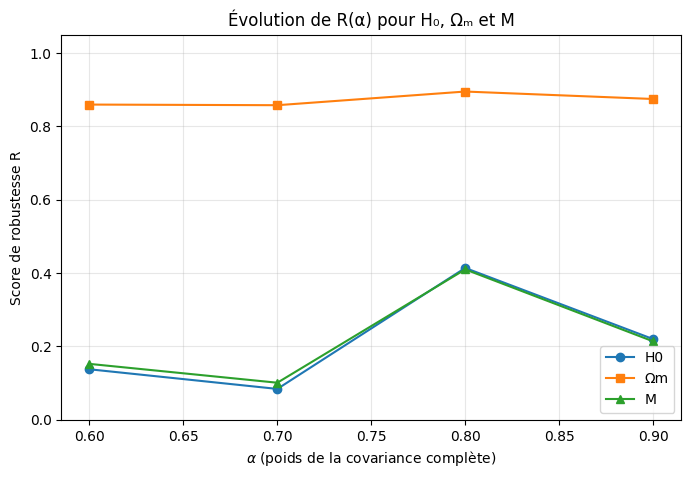

In [25]:
import matplotlib.pyplot as plt

# On suppose que tu as déjà df (avec colonnes: alpha, param, R)
# Si tu as df_pivot comme dans le bloc précédent, on peut l'utiliser directement
df_plot = df.pivot(index="alpha", columns="param", values="R")

plt.figure(figsize=(8,5))

for param, style in zip(["H0","Ωm","M"], ["-o","-s","-^"]):
    plt.plot(df_plot.index, df_plot[param], style, label=param)

plt.xlabel(r"$\alpha$ (poids de la covariance complète)")
plt.ylabel("Score de robustesse R")
plt.title("Évolution de R(α) pour H₀, Ωₘ et M")
plt.ylim(0,1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


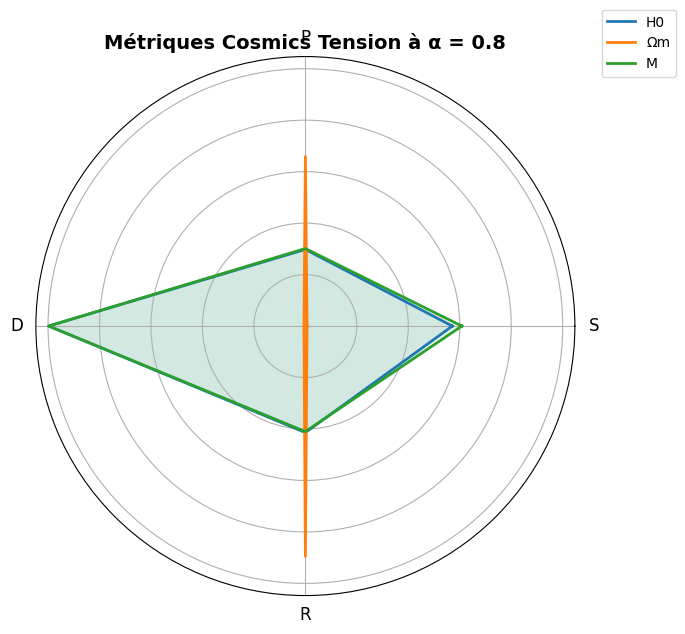

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# Filtrer les résultats pour alpha = 0.8
df_alpha = df[df["alpha"] == 0.8]

# Axes du radar
labels = ["S", "P", "D", "R"]
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # fermer la boucle

# Initialiser le plot
plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

# Tracer chaque paramètre
for _, row in df_alpha.iterrows():
    values = [row[l] for l in labels]
    values += values[:1]  # fermer la boucle
    ax.plot(angles, values, linewidth=2, label=row["param"])
    ax.fill(angles, values, alpha=0.1)

# Personnalisation
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels([])
plt.title("Métriques Cosmics Tension à α = 0.8", fontsize=14, weight="bold")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


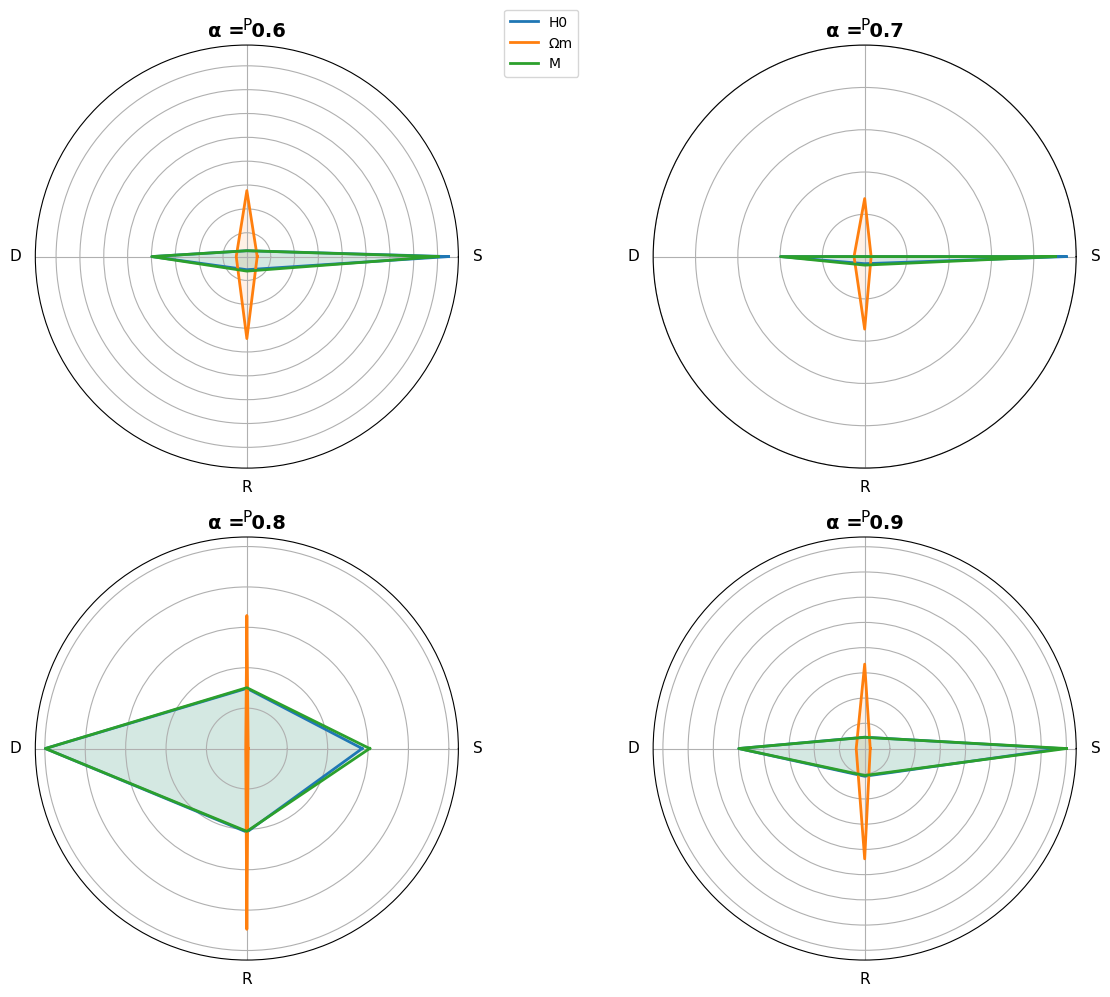

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# On suppose que tu as déjà le DataFrame df avec colonnes: alpha, param, S, P, D, R
alphas = [0.6, 0.7, 0.8, 0.9]
params = ["H0", "Ωm", "M"]
metrics = ["S", "P", "D", "R"]

num_vars = len(metrics)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # fermer la boucle

# Créer la figure avec 2x2 sous-plots
fig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True), figsize=(12, 10))
axs = axs.flatten()

for i, alpha in enumerate(alphas):
    ax = axs[i]
    subset = df[df["alpha"] == alpha]
    for param in params:
        row = subset[subset["param"] == param].iloc[0]
        values = [row[m] for m in metrics]
        values += values[:1]  # fermer la boucle
        ax.plot(angles, values, linewidth=2, label=param)
        ax.fill(angles, values, alpha=0.1)
    ax.set_title(f"α = {alpha}", fontsize=14, weight="bold")
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=11)
    ax.set_yticklabels([])
    ax.grid(True)
    if i == 0:  # légende seulement sur le premier
        ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()
